In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 204ms/step - loss: 0.5940 - root_mean_squared_error: 0.7707 - val_loss: 0.3862 - val_root_mean_squared_error: 0.6214
Epoch 2/50
53/53 [==============================] - 9s 182ms/step - loss: 0.2639 - root_mean_squared_error: 0.5137 - val_loss: 0.2312 - val_root_mean_squared_error: 0.4808
Epoch 3/50
53/53 [==============================] - 10s 183ms/step - loss: 0.1307 - root_mean_squared_error: 0.3615 - val_loss: 0.2088 - val_root_mean_squared_error: 0.4569
Epoch 4/50
53/53 [==============================] - 10s 188ms/step - loss: 0.1292 - root_mean_squared_error: 0.3594 - val_loss: 0.1964 - val_root_mean_squared_error: 0.4431
Epoch 5/50
53/53 [==============================] - 1s 21ms/step - loss: 0.1246 - root_mean_squared_error: 0.3529 - val_loss: 0.2017 - val_root_mean_squared_error: 0.4491
Epoch 6/50
53/53 [==============================] - 10s 188ms/step - loss: 0.1160 - root_mean_squared_error: 0.3405 - val_loss: 0.1850 - v

53/53 [==============================] - 10s 190ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 31/50
53/53 [==============================] - 1s 23ms/step - loss: 0.0289 - root_mean_squared_error: 0.1701 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806
Epoch 32/50
53/53 [==============================] - 9s 181ms/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517
Epoch 33/50
53/53 [==============================] - 1s 23ms/step - loss: 0.0278 - root_mean_squared_error: 0.1667 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1661
Epoch 34/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1546
Epoch 35/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710 - val_loss: 0.0244 - val_root_mean

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.8108885010083515 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

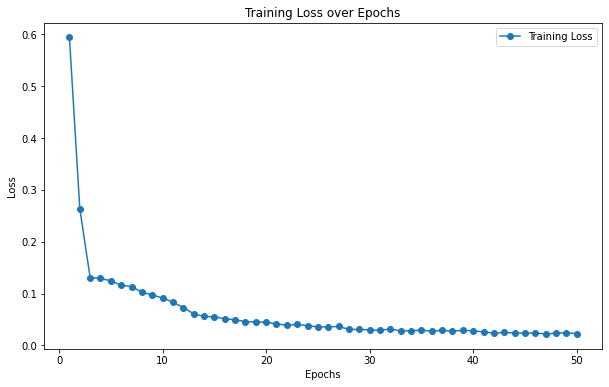

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

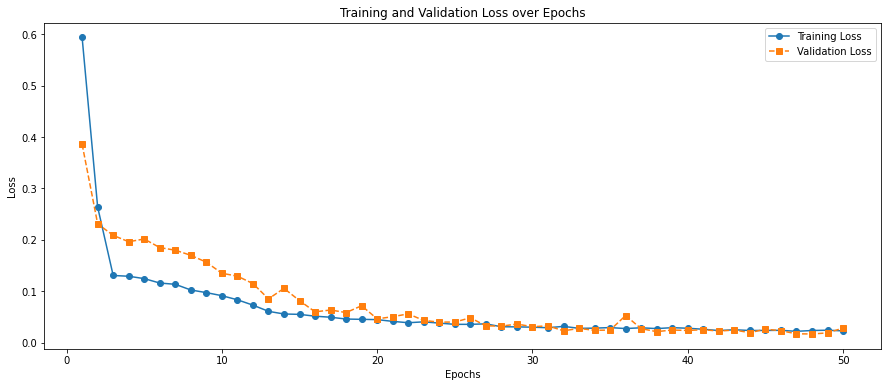

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 15ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.11138628121311633
MAE : 0.08087723640693457


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,839873.125000,917006.278
1,886244.812500,906368.363
2,914472.687500,917403.622
3,922174.937500,910653.838
4,864771.687500,822319.125
5,684356.750000,557314.102
6,391822.062500,197129.525
7,193966.109375,75730.217
8,113462.906250,59608.479
9,249231.890625,88785.283


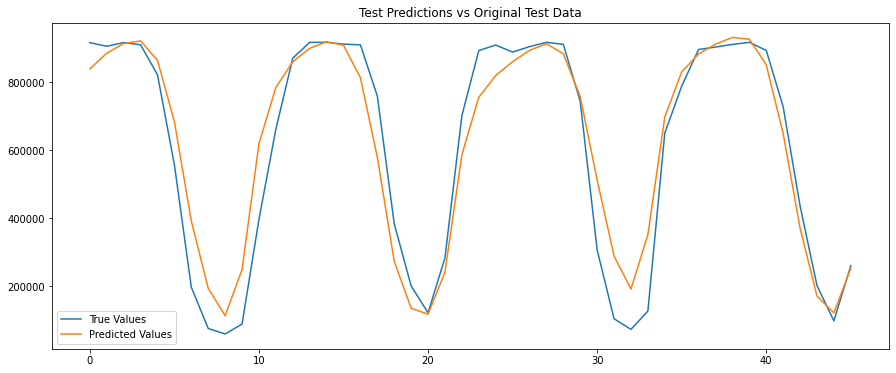

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

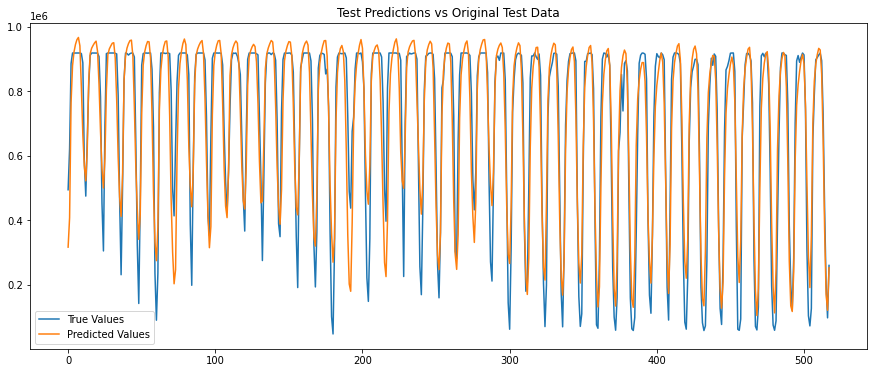

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()